# Football Player Data Analysis Over Time
Author: Olеksаndr Sоlоvеi (No 126784)
Date: October 24, 2024
Repository: https://github.com/s126784/fcd/

## Project Objectives

The overall goal of the project is to build an engine that collects, enriches, and analyzes football player data from Transfermarkt  and portuguese web archive. The project aims to provide meaningful insights on football player trends, their relevance in different time periods, and how web data can contribute to historical analysis in sports.

- Utilize web scraping techniques to gather football player data from multiple sources.
- Implement a process to query historical web snapshots from arquivo.pt 
- Perform exploratory data analysis using python data manipulation libraries
- Store the processed and enriched data into CSV files

## Similar Works

https://yulasozen.medium.com/predicting-football-players-market-value-using-machine-learning-b28be298e91e   The paper utilized data scraped from Transfermarkt to predict future player values based on factors such as age, performance, and position.

 - Focused on performance metrics and player attributes
 - Demonstrated success in value prediction using historical data


My approach extends existing research by:

 - Incorporating web presence metrics
 - Adding temporal analysis
 - Focusing on Portuguese national team players

## Process Flow
1. Set up web scraping environment
2. Implement caching mechanism
3. Collect Transfermarkt data
4. Collect arquivo.pt data
5. Store raw data

## Expected Outputs
- Raw HTML files in /snapshots/*.html
- JSON response files in /snapshots/*.json
- Initial CSV compilation in /data/*.csv

## Data adquisition

The data was collected from Transfermarkt and arquivo.pt. Transfermarkt is a website that provides football player data, including player names, market values, and player positions. The data was collected using web scraping techniques. The arquivo.pt is a web archive that stores historical web snapshots. The data was collected using the arquivo.pt API.

## Methodology

### Data Collection

#### Primary Data Sources
    - Transfermarkt scraping for market values
    - Arquivo.pt API for historical web presence

#### Data Collection Process
 - Web scraping with error handling and rate limiting
 - Caching mechanism for efficiency
 - Data validation and cleaning procedures

In [40]:
import pandas as pd
import io
import requests

SAMPLE_YEAR = 2014

def get_transfermarkt_data(year):

    # try retrieve from cache
    try:
        with open(f'snapshots/portugal_{year}.html', 'r') as f:
            return f.read()
    except FileNotFoundError:
        pass

    try:
        url = f'https://www.transfermarkt.com/portugal/kader/verein/3300/plus/0/galerie/0?saison_id={year}'
        # we need to emulate chrome browser to get the data
        r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})

        # store raw html
        with open(f'snapshots/portugal_{year}.html', 'wb') as f:
            f.write(r.content)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {year}: {e}")

    return r.text

In [41]:
res = get_transfermarkt_data(SAMPLE_YEAR)
# return first 100 characters
print(res[:21])

<!DOCTYPE html>
<html


It returns plain HTML, which can be parsed using pandas framework.

In [42]:
df_list = pd.read_html(io.StringIO(res))
data = df_list[1]
data.head()

,#,Player,Age,Club,Market value
0,12.0,Rui Patrício Goalkeeper,27.0,NaN,€18.00m
1,NaN,Rui Patrício,NaN,NaN,NaN
2,NaN,Goalkeeper,NaN,NaN,NaN
3,1.0,Anthony Lopes Goalkeeper,24.0,NaN,€10.00m
4,NaN,Anthony Lopes,NaN,NaN,NaN


In [43]:
def normalizeValue(value):
    """Convert $xx.00m to xx000000"""
    if value == '-':
        return 0
    if value[-1] == 'm':
        return int(float(value[1:-1]) * 1000000)
    if value[-1] == 'k':
        return int(float(value[1:-1]) * 1000)

def normalizePlayer(name):
    """Convert 'Name Position' to 'Name', 'Position'"""
    positions = ['Centre-Forward', 'Goalkeeper', 'Centre-Back', 'Right-Back', 'Left-Back', 'Defensive Midfield', 'Central Midfield', 'Attacking Midfield', 'Left Winger', 'Right Winger', 'Right Midfield', 'Left Midfield', 'Second Striker']
    positions_shorts = ['CF', 'GK', 'CB', 'RB', 'LB', 'DM', 'CM', 'AM', 'LW', 'RW', 'RM', 'LM', 'SS']
    # return name, position
    for pos, short in zip(positions, positions_shorts):
        if name.endswith(pos):
            return name[:-len(pos)].strip(), short

def normalizeId(id):
    return int(id)

# clean empty rows (where '#' field is empty)
data = data[data['#'].notnull()]

#remove Club column
data = data.drop(columns=['Club'])

# normalize values
data['Market value'] = data['Market value'].map(normalizeValue)

# convert Player field to Name and Position fields
data['Name'], data['Position'] = zip(*data['Player'].map(normalizePlayer))

# convert ID to int
data['#'] = data['#'].map(normalizeId)
data.head()

,#,Player,Age,Market value,Name,Position
0,12,Rui Patrício Goalkeeper,27.0,18000000,Rui Patrício,GK
3,1,Anthony Lopes Goalkeeper,24.0,10000000,Anthony Lopes,GK
6,22,Beto Goalkeeper,33.0,4000000,Beto,GK
9,1,Eduardo Goalkeeper,32.0,2500000,Eduardo,GK
12,3,Pepe Centre-Back,32.0,15000000,Pepe,CB


In [44]:
# only top 10 by Market value
data = data.sort_values('Market value', ascending=False).head(12)
data.head()

,#,Player,Age,Market value,Name,Position
126,7,Cristiano Ronaldo Centre-Forward,30.0,120000000,Cristiano Ronaldo,CF
72,6,William Carvalho Defensive Midfield,23.0,22000000,William Carvalho,DM
78,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM
36,5,Fábio Coentrão Left-Back,27.0,18000000,Fábio Coentrão,LB
0,12,Rui Patrício Goalkeeper,27.0,18000000,Rui Patrício,GK


In [45]:
data.to_csv(f'data/portugal_{SAMPLE_YEAR}.csv', index=False)

Repeat these steps for all years from 2012 to 2022. The parsed data is stored in the data folder.

Now that we have the initial data, we can extend it by adding more features. Using arquivo.pt, we can query historical web snapshots and extract additional information about the players. 

To reduce the number of requests, we can use snapshots of the previous requests. This way, we can avoid querying the same data multiple times.

In [46]:
import urllib.parse
import json
import os

def extend_data(data, year):
    search_results = []

    for i, row in data.iterrows():

        fname = urllib.parse.quote_plus(row['Player'])

        if (os.path.isfile(f'snapshots/{year}_{fname}.json')):
            with open(f'snapshots/{year}_{fname}.json','r') as f:
                snapshot = f.read()
                arquive_data = json.loads(snapshot)
        else:
            params = {
                'q': row['Name'],
                'from': f'{year}0101000000',
                'to': f'{year}1231235959',
                'fields': 'title,snippet,originalURL,timestamp',
            }
            url = 'https://arquivo.pt/textsearch'
            try:
                response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, params=params)
                response.raise_for_status()
                arquive_data = response.json()
                with open(f'snapshots/{year}_{fname}.json', 'w') as f:
                    json.dump(arquive_data, f, indent=4)
            except requests.exceptions.RequestException as e:
                print(f"Error fetching data for {row['Name']}: {e}")
                raise


        estimated_nr_results = arquive_data['estimated_nr_results']
        search_results.append(estimated_nr_results)

    data['search_results'] = search_results
    return data


data_with_arquivo_info = extend_data(data, SAMPLE_YEAR)
data_with_arquivo_info.head()

,#,Player,Age,Market value,Name,Position,search_results
126,7,Cristiano Ronaldo Centre-Forward,30.0,120000000,Cristiano Ronaldo,CF,8631215
72,6,William Carvalho Defensive Midfield,23.0,22000000,William Carvalho,DM,2809567
78,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1431291
36,5,Fábio Coentrão Left-Back,27.0,18000000,Fábio Coentrão,LB,503646
0,12,Rui Patrício Goalkeeper,27.0,18000000,Rui Patrício,GK,1485432


In [47]:
#save data to csv
data_with_arquivo_info.to_csv(f'data/portugal_{SAMPLE_YEAR}_plus.csv', index=False)

In [48]:
# Dataset Overview
print(f"Total players analyzed: {len(data)}")
# make basic analysis
print(f"Average value: €{data_with_arquivo_info['Market value'].mean():,.2f}")
print(f"Median value: €{data_with_arquivo_info['Market value'].median():,.2f}")
print(f"Highest value: €{data_with_arquivo_info['Market value'].max():,.2f}")
print(f"Most valuable position: {data_with_arquivo_info.groupby('Position')['Market value'].mean().idxmax()}")

Total players analyzed: 12
Average value: €23,395,833.33
Median value: €15,500,000.00
Highest value: €120,000,000.00
Most valuable position: CF


In [49]:
# calculate correlation
data_with_arquivo_info[['Market value', 'search_results']].corr()

,Market value,search_results
Market value,1.000000,0.930971
search_results,0.930971,1.000000


<Axes: xlabel='search_results', ylabel='Count'>

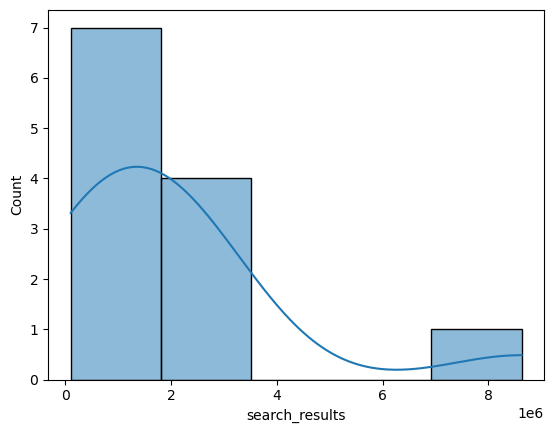

In [50]:
import seaborn as sns
# Analyze the data
# Use histplot to show the distribution of search results
sns.histplot(data=data, x='search_results', kde=True)

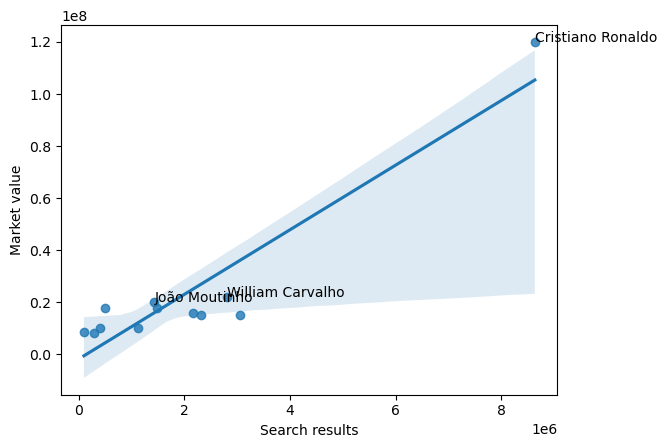

In [51]:
import matplotlib.pyplot as plt
# show the plot
sns.regplot(data=data_with_arquivo_info, x='search_results', y='Market value', fit_reg=True)
plt.xlabel('Search results')
plt.ylabel('Market value')

top_players = data_with_arquivo_info.nlargest(3, 'Market value')
for i, row in top_players.iterrows():
    plt.text(row['search_results'], row['Market value'], row['Name'])
plt.show()

Let's try to find outlier players in the dataset. We can use the both metrics of the players as a metric to identify outliers. 

<Axes: ylabel='Market value'>

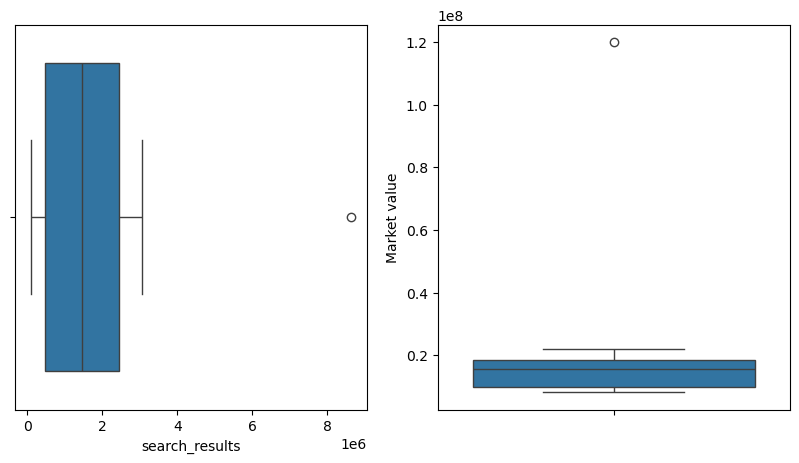

In [52]:
# show two boxblots (one left, other right) to compare distribution of market value and search results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(data=data_with_arquivo_info, x='search_results', ax=axs[0])
sns.boxplot(data=data_with_arquivo_info, y='Market value', ax=axs[1])

In [53]:
def remove_outliers(data):
    # remove outliers
    # q1 = data['Market value'].quantile(0.25)
    # q3 = data['Market value'].quantile(0.75)
    # iqr = q3 - q1
    # data_without_outliers = data[(data['Market value'] > q1 - 1.5 * iqr) & (data['Market value'] < q3 + 1.5 * iqr)]

    q1 = data['search_results'].quantile(0.2)
    q3 = data['search_results'].quantile(0.8)
    iqr = q3 - q1
    data_without_outliers = data[(data['search_results'] > q1 - 1.5 * iqr) & (data['search_results'] < q3 + 1.5 * iqr)]
    return data_without_outliers

data_without_outliers = remove_outliers(data_with_arquivo_info)


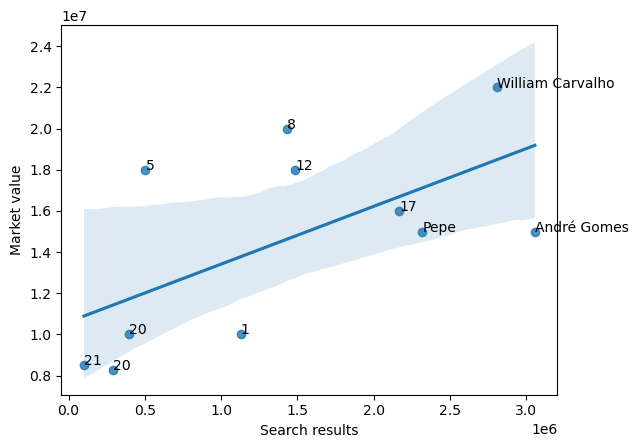

In [54]:
# show the plot agains
sns.regplot(data=data_without_outliers, x='search_results', y='Market value', fit_reg=True)
plt.xlabel('Search results')
plt.ylabel('Market value')

# add player names and ids
top_players = data_without_outliers.nlargest(3, 'search_results')
for i, row in top_players.iterrows():
    plt.text(row['search_results'], row['Market value'], row['Name'])

rest_players = data_without_outliers.drop(top_players.index)
for i, row in rest_players.iterrows():
    plt.text(row['search_results'], row['Market value'], row['#'])

plt.show()

In [55]:
# Check the correlation of the data
aggregated_data = []
for year in range(2014, 2018):
    year_data = pd.read_csv(f'data/portugal_{year}_plus.csv')
    corr = year_data[['Market value', 'search_results']].corr().iloc[0, 1]
    aggregated_data.append(year_data)
    print(year, corr)
aggregated_df = pd.concat(aggregated_data)
aggregated_df.head()
total_corr = aggregated_df[['Market value', 'search_results']].corr().iloc[0, 1]
print("Aggregated data correlation", total_corr)

2014 0.9309709921317573
2015 0.8734146728851334
2016 0.8669629014111991
2017 0.7986268446746246
Aggregated data correlation 0.7780518692776603


Repeat these steps for all years from 2014 to 2017. The parsed data is stored in the data folder.

In [56]:
dfs = dict()
years = range(2014, 2018)
for year in years:
    dfs[year] = pd.read_csv(f'data/portugal_{year}_plus.csv')
    dfs[year] = remove_outliers(dfs[year])


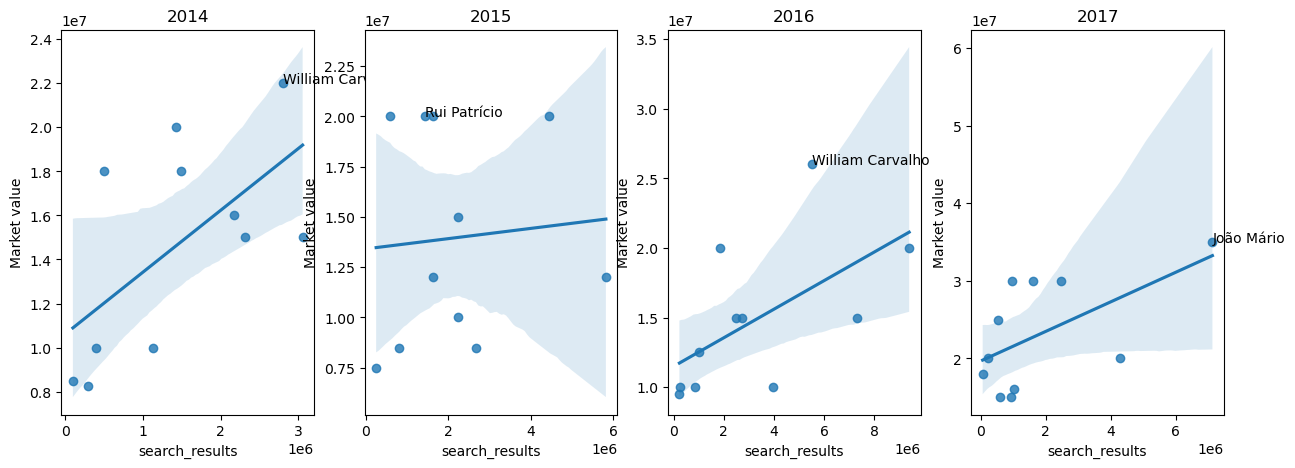

In [57]:
# show the plots for all years
fig, axs = plt.subplots(nrows=1, ncols=len(years), figsize=(15, 5))
for i, year in enumerate(years):
    sns.regplot(data=dfs[year], x='search_results', y='Market value', fit_reg=True, ax=axs[i])
    axs[i].set_title(year)

    top_players = dfs[year].nlargest(1, 'Market value')
    for j, row in top_players.iterrows():
        axs[i].text(row['search_results'], row['Market value'], row['Name'])

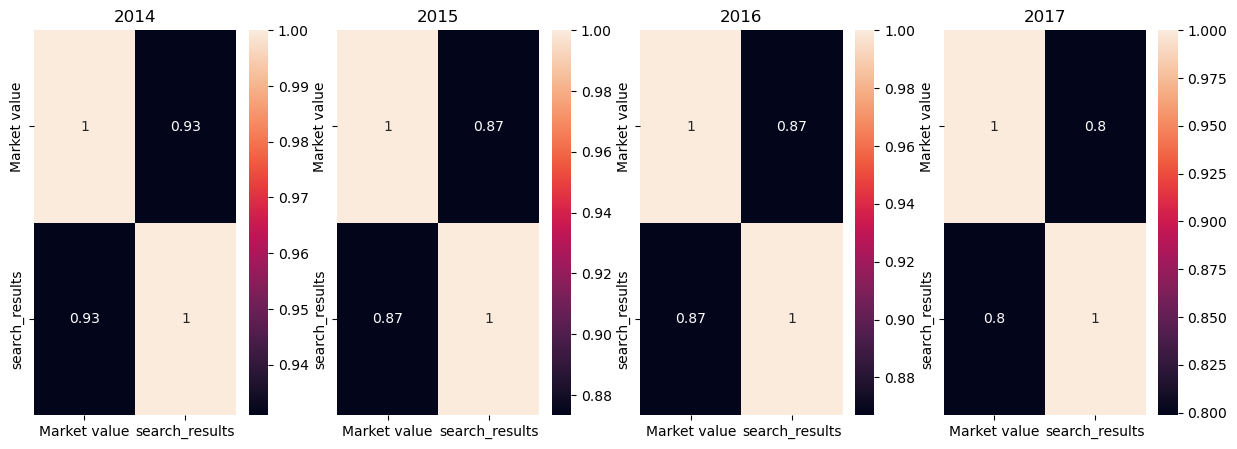

In [58]:
# plot correlation for all years
fig, axs = plt.subplots(nrows=1, ncols=len(years), figsize=(15, 5))
for i, year in enumerate(years):
    data = pd.read_csv(f'data/portugal_{year}_plus.csv')
    sns.heatmap(data[['Market value', 'search_results']].corr(), annot=True, ax=axs[i])
    axs[i].set_title(year)
plt.show()

## Future Improvements

### Analysis Enhancements

 - Player clustering analysis
 - Advanced time series modeling
 - Sentiment analysis of web content
 - Machine learning for value prediction

### Data Enrichment

 - Additional data sources integration
 - Performance statistics inclusion
 - Social media metrics

## Conclusions

The analysis demonstrates a strong relationship between player market values and web presence, with this correlation varying over time and across positions.

## References

 - Sozen, Y. (2023). Predicting Football Players Market Value Using Machine Learning
 - Transfermarkt Documentation
 - Arquivo.pt API Documentation